© 2024 Nokia
Licensed under the BSD 3 Clause Clear License  
SPDX-License-Identifier: BSD-3-Clause-Clear

In [53]:
import math
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import sklearn
import sklearn.manifold
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial import distance

num_classes = 2
sns.set(style='white', context="poster", font='Work Sans Regural', palette=sns.color_palette(["#1F968BFF", "#FDE725FF", "#d1d3d4"], num_classes))

In [54]:
dataset = 'GLOBEM'

models = [
    os.path.join('SimCLR', dataset, '20231128-152529_e200_esTrue_bs128_wTrue_f2_fl', 'simclr.frozen.1.41.hdf5'),
    os.path.join('SimCLR', dataset, '20231128-152400_e200_esTrue_bs128_wTrue_f1_m', 'simclr.frozen.1.58.hdf5'),
    os.path.join('SimCLR', dataset, '20231128-152548_e200_esTrue_bs128_wTrue_f0', 'simclr.frozen.1.56.hdf5'),
    os.path.join('SimCLR', dataset, '20231128-152601_e200_esTrue_bs128_wTrue_f1', 'simclr.frozen.1.08.hdf5'),
    os.path.join('SimCLR', dataset, '20231128-152630_e200_esTrue_bs128_wTrue_f2', 'simclr.frozen.1.19.hdf5'),
    os.path.join('SimCLR', dataset, '20231128-152654_e200_esTrue_bs128_wTrue_f3', 'simclr.frozen.1.71.hdf5'),
    os.path.join('Supervised', dataset, '20231115-091914_l2_e200_esTrue_bs64_wTrue', 'supervised.finetuned.hdf5')
]

intermediate_layer = 7  # last CNN layer

In [55]:
model_file_name = models[1]
model_name = '1m'
test = (np.load(os.path.join('SimCLR', dataset, 'test_x.npy')),
           np.load(os.path.join('SimCLR', dataset, 'test_y.npy')))

In [56]:
test_listfile = pd.read_csv(os.path.join('..', '..', 'datasets', dataset, 'test_listfile.csv'))
subjects = pd.read_csv(os.path.join('..', '..',  'datasets', dataset, 'demographics.csv'))
# extract subject_id from stay
# regex = r"(?:^\d+)"
# test_listfile.loc[:, "SUBJECT_ID"] = test_listfile.stay.apply(lambda stay: re.search(regex, stay).group(0))
# test_listfile.SUBJECT_ID = test_listfile.SUBJECT_ID.astype(int)
# test_listfile.drop(['stay'], axis=1, inplace=True)
subjects.head

<bound method NDFrame.head of       PID  gender   age      race  generation  disability
0       1     1.0  18.0     Asian         2.0         0.0
1       2     2.0  18.0     White         4.0         0.0
2       3     2.0  18.0  Biracial         4.0         0.0
3       4     2.0  18.0     Asian         2.0         0.0
4       5     2.0  18.0     Asian         2.0         0.0
..    ...     ...   ...       ...         ...         ...
833  1220     2.0  20.0     Asian         1.0         1.0
834  1221     1.0  21.0     Asian         1.0         1.0
835  1222     2.0  19.0     Asian         2.0         1.0
836  1223     3.0  18.0     Asian         2.0         1.0
837  1224     4.0  19.0     White         3.0         1.0

[838 rows x 6 columns]>

In [57]:
# test_listfile = test_listfile.merge(subjects, how='left', on='PID')
test_listfile.gender = test_listfile.gender.apply(lambda v: 'M' if v==1 else ('F' if v==2 else ('Trans' if v==3 else 'Queer' if v==4 else 'Other')))
test_listfile.disability = test_listfile.disability.apply(lambda v: 'Yes' if v==1 else 'No')
test_listfile.drop(columns=['age', 'generation', 'year'], inplace=True)
test_listfile.head

<bound method NDFrame.head of          PID gender   race disability
0     1221.0      M  Asian        Yes
1     1221.0      M  Asian        Yes
2     1221.0      M  Asian        Yes
3     1221.0      M  Asian        Yes
4     1221.0      M  Asian        Yes
...      ...    ...    ...        ...
1078   999.0      M  Asian         No
1079   999.0      M  Asian         No
1080   999.0      M  Asian         No
1081   999.0      M  Asian         No
1082   999.0      M  Asian         No

[1083 rows x 4 columns]>

# All (random) users test -> Gender-based coloring

In [58]:
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
# predictions
np_test = (np.load(os.path.join(os.path.join('SimCLR', dataset), 'test_x.npy')),
           np.load(os.path.join(os.path.join('SimCLR', dataset), 'test_y.npy')))
probs = model.predict(np_test[0])
predictions = np.argmax(probs, axis=1)
test_listfile.loc[:, "y_pred"] = predictions

# representations
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(test[0], batch_size=600)
print(intermediate_representation.shape)
layer_model.summary()

(1083, 96)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 1390)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 32)            1067552   
_________________________________________________________________
dropout (Dropout)            (None, 28, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 28, 96)            49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 96)

In [67]:
tsne_model = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=42, n_iter=7000)
projected_X = tsne_model.fit_transform(intermediate_representation)
projected_X

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1083 samples in 0.001s...
[t-SNE] Computed neighbors for 1083 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1083
[t-SNE] Computed conditional probabilities for sample 1083 / 1083
[t-SNE] Mean sigma: 0.872630
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.755219
[t-SNE] KL divergence after 6600 iterations: 0.972128


array([[ 34.95355 , -16.014679],
       [ 35.699177, -13.225596],
       [ 35.84618 , -12.776589],
       ...,
       [-28.072655,  29.367035],
       [-27.171827,  32.997334],
       [-37.511116,  22.094828]], dtype=float32)

In [69]:
test_listfile

,PID,gender,race,disability,y_pred
0,1221.0,M,Asian,Yes,0.0
1,1221.0,M,Asian,Yes,0.0
2,1221.0,M,Asian,Yes,0.0
3,1221.0,M,Asian,Yes,0.0
4,1221.0,M,Asian,Yes,0.0
...,...,...,...,...,...
1078,999.0,M,Asian,No,0.0
1079,999.0,M,Asian,No,0.0
1080,999.0,M,Asian,No,0.0
1081,999.0,M,Asian,No,0.0


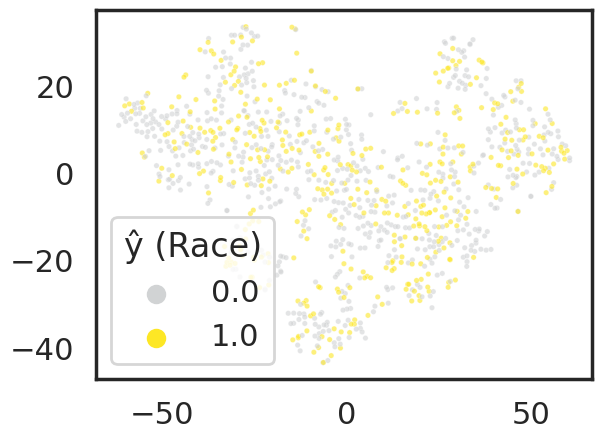

In [70]:
plt.clf()
prot_attr = 'race'
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test_listfile['y_pred'],
    # hue_order =
    palette=sns.color_palette(["#d1d3d4", "#FDE725FF"]),
    #  "#1F968BFF"
    # palette=sns.color_palette(["red", "#d1d3d4", "#1F968BFF", ]),
    # legend="full",
    s=15,
    alpha=0.6,
)

plt.legend(title='ŷ (Race)')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-{}-w-go.pdf'.format(model_name, prot_attr)), bbox_inches='tight', transparent=True)

In [51]:
def color_encoding_gender(prot_attr, colored_attribute, y_pred):
    if prot_attr != colored_attribute:
        return 'ŷ ({})'.format('F' if colored_attribute == 'M' else 'M')
    elif y_pred == 1:
        return '1 ({})'.format(colored_attribute)
    else:
        return '0 ({})'.format(colored_attribute)

# <65 (1)
def color_encoding_age(prot_attr, colored_attribute, y_pred):
    prot_attr = ('<65' if prot_attr == 1 else '>=65')
    if prot_attr != colored_attribute:
        return 'ŷ ({})'.format('<65' if colored_attribute == '>=65' else '>=65')
    elif y_pred == 1:
        return '1 ({})'.format(colored_attribute)
    else:
        return '0 ({})'.format(colored_attribute)
    
def color_encoding_race(prot_attr, colored_attribute, y_pred):
    if prot_attr != colored_attribute:
        return ''
    elif y_pred == 1:
        return '1 ({})'.format(colored_attribute)
    else:
        return '0 ({})'.format(colored_attribute)

test_listfile.loc[:, "color_encoding_gender"] = test_listfile.apply(lambda row: color_encoding_gender(row['gender'], 'Other', row['y_pred']), axis=1)
test_listfile.loc[:, "color_encoding_race"] = test_listfile.apply(lambda row: color_encoding_race(row['race'], 'White', row['y_pred']), axis=1)

# test_listfile.loc[:, "color_encoding_age"] = test_listfile.apply(lambda row: color_encoding_age(row['AGE'], '<65', row['y_pred']), axis=1)
test_listfile

,PID,gender,race,disability,y_pred,color_encoding_gender,color_encoding_race
0,1221.0,M,Asian,Yes,0.0,ŷ (M),
1,1221.0,M,Asian,Yes,0.0,ŷ (M),
2,1221.0,M,Asian,Yes,0.0,ŷ (M),
3,1221.0,M,Asian,Yes,0.0,ŷ (M),
4,1221.0,M,Asian,Yes,0.0,ŷ (M),
...,...,...,...,...,...,...,...
1078,999.0,M,Asian,No,0.0,ŷ (M),
1079,999.0,M,Asian,No,0.0,ŷ (M),
1080,999.0,M,Asian,No,0.0,ŷ (M),
1081,999.0,M,Asian,No,0.0,ŷ (M),


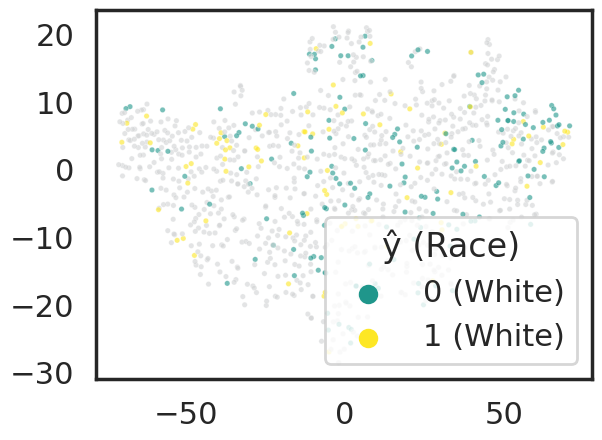

In [45]:
plt.clf()
prot_attr = 'race'
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test_listfile["color_encoding_{}".format(prot_attr)],
    # hue_order =
    palette=sns.color_palette(["#d1d3d4", "#1F968BFF", "#FDE725FF"]),
    # palette=sns.color_palette(["red", "#d1d3d4", "#1F968BFF", ]),
    # legend="full",
    s=15,
    alpha=0.6,
)

plt.legend(title='ŷ (Race)')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-{}-w-go.pdf'.format(model_name, prot_attr)), bbox_inches='tight', transparent=True)

## Seperate rows based on gender

In [12]:
test_listfile.gender.value_counts()

F        590
M        459
Trans     12
Queer     11
Other     11
Name: gender, dtype: int64

In [13]:
male_rows = test_listfile.index[test_listfile["gender"] == "M"].tolist()
female_rows = test_listfile.index[test_listfile["gender"] == "F"].tolist()
other_rows = test_listfile.index[(test_listfile["gender"] == "Trans") | (test_listfile["gender"] == "Queer") | (test_listfile["gender"] == "Other")].tolist()
print("Male rows: {} and Female rows: {} and Other rows: {}".format(len(male_rows), len(female_rows), len(other_rows)))

Male rows: 459 and Female rows: 590 and Other rows: 34


## Median Female vs Median Male

In [14]:
def get_median(x_subset, y_subset=None):
    if y_subset is None:
        return np.median(x_subset)
    else:
        return np.median(x_subset), np.median(y_subset)

def get_mean(arr_subset, y_subset=None):
    if y_subset is None:
        return arr_subset.mean(axis=0)
    else:
        return np.mean(arr_subset), np.mean(y_subset)

In [15]:
# Before dimensionality reduction -> find the mean point (centroid)
f_median = get_median(intermediate_representation[female_rows,:])
f_median = np.reshape(f_median, (1,-1))
m_median = get_median(intermediate_representation[male_rows,:])
m_median = np.reshape(m_median, (1,-1))
o_median = get_median(intermediate_representation[other_rows,:])
o_median = np.reshape(o_median, (1,-1))

In [16]:
print("Distance between median male and female in the original space: {}".format(distance.cityblock(f_median, m_median)))

Distance between median male and female in the original space: 0.000712856650352478


In [17]:
f_x_median, f_y_median = get_median(projected_X[female_rows,0], projected_X[female_rows,1])
print("Female x: {} and y: {}".format(f_x_median, f_y_median))
m_x_median, m_y_median = get_median(projected_X[male_rows,0], projected_X[male_rows,1])
print("Male x: {} and y: {}".format(m_x_median, m_y_median))
o_x_median, o_y_median = get_median(projected_X[other_rows,0], projected_X[other_rows,1])
print("Other x: {} and y: {}".format(o_x_median, o_y_median))

Female x: -1.8012828826904297 and y: 0.05553142726421356
Male x: 0.015659060329198837 and y: 0.32710397243499756
Other x: 21.815753936767578 and y: 4.936430931091309


In [18]:
print("Distance between median male and female in the lower-dimensional space: {}".format(distance.cityblock([f_x_median, f_y_median], [m_x_median, m_y_median])))

Distance between median male and female in the lower-dimensional space: 2.088514566421509


findfont: Font family ['Work Sans Regural'] not found. Falling back to DejaVu Sans.


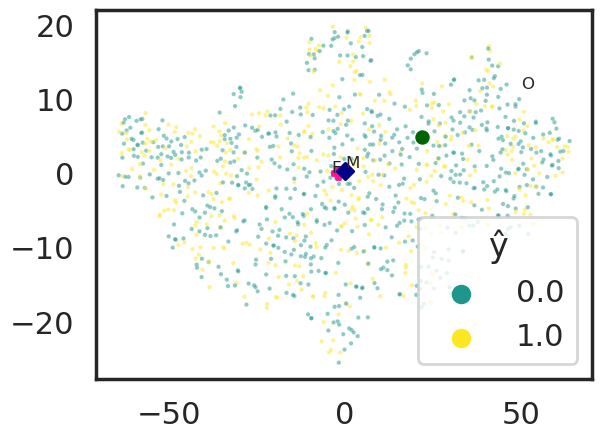

In [19]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#1F968BFF", "#FDE725FF"]),
    legend="full",
    s=10,
    alpha=0.5,
)
fp = plt.scatter(f_x_median, f_y_median, c='deeppink', marker='P', s=70)
plt.text(f_x_median * (1 + 1.1), f_y_median * (1 + 1.1) , "F", fontsize=12)
mp = plt.scatter(m_x_median, m_y_median, c='darkblue', marker='D', s=70)
plt.text(m_x_median * (1 + 1.3), m_y_median * (1 + 1.3) , "M", fontsize=12)
op = plt.scatter(o_x_median, o_y_median, c='darkgreen', marker='o', s=70)
plt.text(o_x_median * (1 + 1.3), o_y_median * (1 + 1.3) , "O", fontsize=12)
plt.legend(title='ŷ')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender_median.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Mean Female vs Mean Male

In [20]:
# Before dimensionality reduction -> find the mean point (centroid)
f_mean = get_mean(intermediate_representation[female_rows,:])
f_mean = np.reshape(f_mean, (1,-1))
m_mean = get_mean(intermediate_representation[male_rows,:])
m_mean = np.reshape(m_mean, (1,-1))
o_mean = get_mean(intermediate_representation[other_rows,:])
o_mean = np.reshape(o_mean, (1,-1))

In [21]:
print("Distance between mean male and female in the original space: {}".format(distance.cityblock(f_mean, m_mean)))

Distance between mean male and female in the original space: 0.48425424098968506


In [22]:
f_x_mean, f_y_mean = get_mean(projected_X[female_rows,0], projected_X[female_rows,1])
print("Female x: {} and y: {}".format(f_x_mean, f_y_mean))
m_x_mean, m_y_mean = get_mean(projected_X[male_rows,0], projected_X[male_rows,1])
print("Male x: {} and y: {}".format(m_x_mean, m_y_mean))
o_x_mean, o_y_mean = get_mean(projected_X[other_rows,0], projected_X[other_rows,1])
print("Other x: {} and y: {}".format(o_x_mean, o_y_mean))

Female x: -0.9710288047790527 and y: -0.7049773931503296
Male x: 0.09920566529035568 and y: -0.5468442440032959
Other x: 20.152069091796875 and y: 4.946761131286621


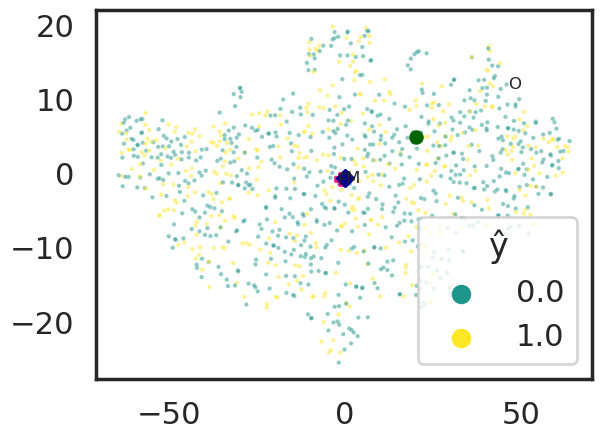

In [23]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#1F968BFF", "#FDE725FF"]),
    legend="full",
    s=10,
    alpha=0.5,
)
fp = plt.scatter(f_x_mean, f_y_mean, c='deeppink', marker='P', s=70)
plt.text(f_x_mean * (1 + 1.1), f_y_mean * (1 + 1.1) , "F", fontsize=12)
mp = plt.scatter(m_x_mean, m_y_mean, c='darkblue', marker='D', s=70)
plt.text(m_x_mean * (1 + 1.3), m_y_mean * (1 + 1.3) , "M", fontsize=12)
op = plt.scatter(o_x_mean, o_y_mean, c='darkgreen', marker='o', s=70)
plt.text(o_x_mean * (1 + 1.3), o_y_mean * (1 + 1.3) , "O", fontsize=12)
plt.legend(title='ŷ')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender_mean.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Medoid Female vs Male (with StackOverflow Implementation)

In [24]:
from sklearn_extra.cluster import KMedoids
# why is Manhattan distance preferred: https://bib.dbvis.de/uploadedFiles/155.pdf
GetMedoid = lambda vX: KMedoids(n_clusters=1, metric='manhattan').fit(vX).cluster_centers_
medoid_f = GetMedoid(intermediate_representation[female_rows,:])
medoid_m = GetMedoid(intermediate_representation[male_rows,:])
medoid_o = GetMedoid(intermediate_representation[other_rows,:])

In [25]:
from scipy.spatial import distance
from scipy.spatial.distance import cityblock
print("Euclidean Distance between median male and female in the original space (not appropriate for high dimensions): {}".format(distance.euclidean(medoid_o, medoid_m)))
print("Manhattan Distance between median male and female in the original space: {}".format(distance.cityblock(medoid_f, medoid_m)))

Euclidean Distance between median male and female in the original space (not appropriate for high dimensions): 0.9919496774673462
Manhattan Distance between median male and female in the original space: 4.615678787231445


In [26]:
medoid_f = GetMedoid(projected_X[female_rows, :])
medoid_m = GetMedoid(projected_X[male_rows, :])
medoid_o = GetMedoid(projected_X[other_rows, :])
print("Euclidean Distance between median male and female in the lower-dimensional space (not appropriate for high dimensions): {}".format(distance.euclidean(medoid_f, medoid_m)))
print("Manhattan Distance between median male and female in the lower-dimensional space: {}".format(distance.cityblock(medoid_f, medoid_m)))

Euclidean Distance between median male and female in the lower-dimensional space (not appropriate for high dimensions): 1.9407531023025513
Manhattan Distance between median male and female in the lower-dimensional space: 2.109119415283203


In [27]:
medoid_f[0,1]

0.0238141

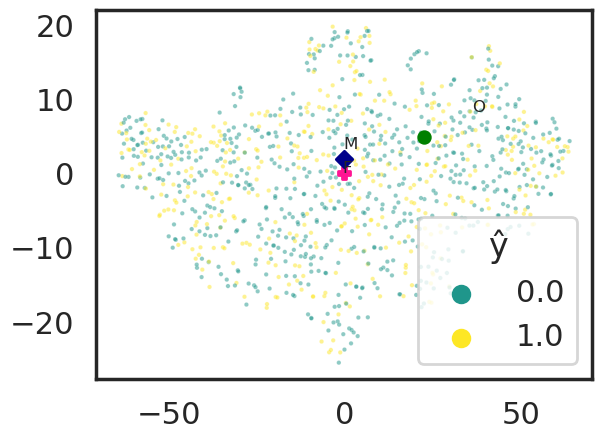

In [28]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#1F968BFF", "#FDE725FF"]),
    legend="full",
    s=10,
    alpha=0.5,
)
fp = plt.scatter(medoid_f[0,0], medoid_f[0,1], c='deeppink', marker='P', s=70)
plt.text(medoid_f[0,0] * (1 + 0.6), medoid_f[0,1] * (1 + 0.6) , "F", fontsize=12)
mp = plt.scatter(medoid_m[0,0], medoid_m[0,1], c='darkblue', marker='D', s=70)
plt.text(medoid_m[0,0] * (1 + 0.6), medoid_m[0,1] * (1 + 0.7) , "M", fontsize=12)
op = plt.scatter(medoid_o[0,0], medoid_o[0,1], c='green', marker='o', s=70)
plt.text(medoid_o[0,0] * (1 + 0.6), medoid_o[0,1] * (1 + 0.7) , "O", fontsize=12)
plt.legend(title='ŷ')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender-medoid.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

## Point closest to mean Female vs Male (custom implementation)

In [29]:
# Before dimensionality reduction -> find the mean point (centroid)
print("X shape: {}".format(intermediate_representation.shape))
f_mean = get_mean(intermediate_representation[female_rows,:])
f_mean = np.reshape(f_mean, (1,-1))
m_mean = get_mean(intermediate_representation[male_rows,:])
m_mean = np.reshape(m_mean, (1,-1))
o_mean = get_mean(intermediate_representation[other_rows,:])
o_mean = np.reshape(o_mean, (1,-1))
print(f_mean.shape)

X shape: (1083, 96)
(1, 96)


In [30]:
# Before dimensionality reduction -> find the closest existing point to the mean (possibly medoid)
from sklearn.metrics import pairwise_distances_argmin_min
# print("Centroid shape: {} - Data shape: {}".format(f_mean.shape, intermediate_representation[female_rows,:].shape))
closest_f_index, closest_f_dist = pairwise_distances_argmin_min(f_mean, intermediate_representation[female_rows,:])
closest_f = intermediate_representation[closest_f_index,:]
# print("Point closest to the female centroid: {}".format(closest_f))
closest_m_index, closest_m_dist = pairwise_distances_argmin_min(m_mean, intermediate_representation[male_rows,:])
closest_m = intermediate_representation[closest_m_index,:]
closest_o_index, closest_o_dist = pairwise_distances_argmin_min(o_mean, intermediate_representation[other_rows,:])
closest_o = intermediate_representation[closest_o_index,:]

In [31]:
from scipy.spatial import distance
from scipy.spatial.distance import cityblock
print("Euclidean Distance between median male and female in the original space (not appropriate for high dimensions): {}".format(distance.euclidean(closest_f, closest_m)))
print("Manhattan Distance between median male and female in the original space: {}".format(distance.cityblock(closest_f, closest_m)))

Euclidean Distance between median male and female in the original space (not appropriate for high dimensions): 0.6973220705986023
Manhattan Distance between median male and female in the original space: 5.28117561340332


In [32]:
# in the lower-dimensional space -> find the medoid equivalent
f_projections = projected_X[female_rows, :]
closest_f_tsne = f_projections[closest_f_index, :]
print("Female medoid: {}".format(closest_f_tsne))
m_projections = projected_X[male_rows, :]
closest_m_tsne = m_projections[closest_m_index, :]
print("Male medoid: {}".format(closest_m_tsne))
o_projections = projected_X[other_rows, :]
closest_o_tsne = o_projections[closest_o_index, :]
print("Other medoid: {}".format(closest_o_tsne))

Female medoid: [[-2.9708612 -4.646705 ]]
Male medoid: [[-3.530455    0.06726541]]
Other medoid: [[30.765453   2.8213894]]


In [33]:
# reshaping
closest_m_tsne = np.reshape(closest_m_tsne, (-1,))
closest_f_tsne = np.reshape(closest_f_tsne, (-1,))
closest_o_tsne = np.reshape(closest_o_tsne, (-1,))
closest_m_tsne.shape

(2,)

In [34]:
print("Euclidean Distance between median male and female in the lower dimensional space: {}".format(distance.euclidean(closest_f_tsne, closest_m_tsne)))
print("Manhattan Distance between median male and female in the lower dimensional space: {}".format(distance.cityblock(closest_f_tsne, closest_m_tsne)))

Euclidean Distance between median male and female in the lower dimensional space: 4.747068881988525
Manhattan Distance between median male and female in the lower dimensional space: 5.273564338684082


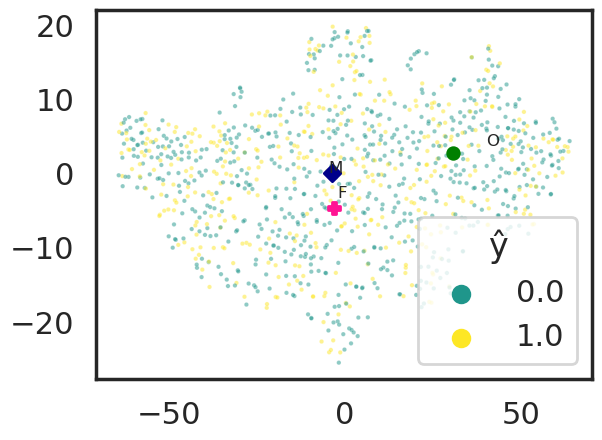

In [35]:
plt.clf()
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=test[1][:,1],
    palette=sns.color_palette(["#1F968BFF", "#FDE725FF"]),
    legend="full",
    s=10,
    alpha=0.5,
)
fp = plt.scatter(closest_f_tsne[0], closest_f_tsne[1], c='deeppink', marker='P', s=70)
plt.text(closest_f_tsne[0] * (1 - 0.3), closest_f_tsne[1] * (1 - 0.3) , "F", fontsize=12)
mp = plt.scatter(closest_m_tsne[0], closest_m_tsne[1], c='darkblue', marker='D', s=70)
plt.text(closest_m_tsne[0] * (1 + 0.3), closest_m_tsne[1] * (1 + 0.3) , "M", fontsize=12)
op = plt.scatter(closest_o_tsne[0], closest_o_tsne[1], c='green', marker='o', s=70)
plt.text(closest_o_tsne[0] * (1 + 0.3), closest_o_tsne[1] * (1 + 0.3) , "O", fontsize=12)
plt.legend(title='ŷ')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender-medoid.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

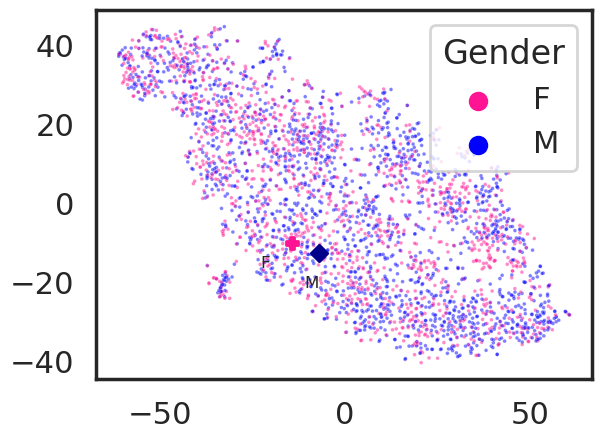

In [158]:
plt.clf()
color_coding = test_listfile["color_encoding_gender"].apply(lambda c: "F" if c=="ŷ (F)" else "M")
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=color_coding,
    palette=sns.color_palette(["deeppink", "blue"]),
    legend="full",
    s=7,
    alpha=0.5,
)

fp = plt.scatter(closest_f_tsne[0], closest_f_tsne[1], c='deeppink', marker='P', s=70)
plt.text(closest_f_tsne[0] * (1 + 0.6), closest_f_tsne[1] * (1 + 0.6) , "F", fontsize=12)
mp = plt.scatter(closest_m_tsne[0], closest_m_tsne[1], c='darkblue', marker='D', s=70)
plt.text(closest_m_tsne[0] * (1 + 0.6), closest_m_tsne[1] * (1 + 0.7) , "M", fontsize=12)
plt.legend(title='Gender')
#  loc='upper left',

fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-gender-medoid-2.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

# Gendered test set

In [105]:
f_test = test[0][test_listfile.GENDER == "F"]
f_test_y = test[1][test_listfile.GENDER == "F"]
m_test = test[0][test_listfile.GENDER == "M"]
m_test_y = test[1][test_listfile.GENDER == "M"]

In [106]:
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(f_test, batch_size=600)
print(intermediate_representation.shape)
layer_model.summary()

(1439, 96)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 76)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            58400     
_________________________________________________________________
dropout (Dropout)            (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 96)             49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 96) 

In [107]:
tsne_model = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=42)
projected_X = tsne_model.fit_transform(intermediate_representation)
projected_X

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1439 samples in 0.001s...
[t-SNE] Computed neighbors for 1439 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1439
[t-SNE] Computed conditional probabilities for sample 1439 / 1439
[t-SNE] Mean sigma: 0.289101
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.368942
[t-SNE] KL divergence after 1000 iterations: 1.328500


array([[-23.17241 ,  20.819963],
       [-15.45338 ,   4.541809],
       [ 11.472048,  -4.679468],
       ...,
       [ -4.124952,  -3.709606],
       [ -5.993708, -15.990616],
       [ 11.176348,  -2.190732]], dtype=float32)

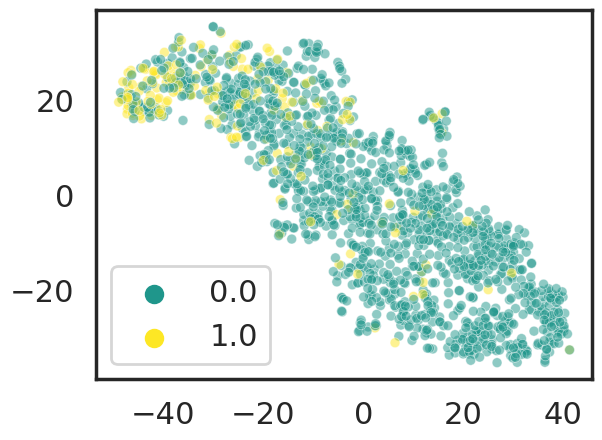

In [108]:
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=f_test_y[:,1],
    # palette=sns.color_palette(["#1F968BFF", "#FDE725FF", "#d1d3d4"],
    legend="full",
    s=50,
    alpha=0.5,
)
fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-f.pdf'.format(model_name)), bbox_inches='tight', transparent=True)

In [109]:
tf.keras.backend.clear_session()
model = tf.keras.models.load_model(model_file_name, compile=False)
layer_model = model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[intermediate_layer].output)
intermediate_representation = layer_model.predict(m_test, batch_size=600)
print(intermediate_representation.shape)
layer_model.summary()
tsne_model = sklearn.manifold.TSNE(n_components=2, verbose=1, random_state=42)
projected_X = tsne_model.fit_transform(intermediate_representation)


(1797, 96)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 48, 76)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            58400     
_________________________________________________________________
dropout (Dropout)            (None, 25, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 64)            32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 96)             49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 96) 

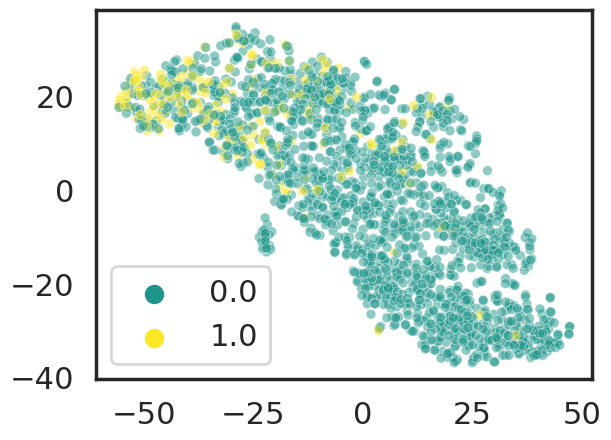

In [110]:
graph = sns.scatterplot(
    x=projected_X[:,0], y=projected_X[:,1],
    hue=m_test_y[:,1],
    # palette=sns.color_palette(["#1F968BFF", "#FDE725FF"], num_classes),
    legend="full",
    s=50,
    alpha=0.5,
)
fig = graph.get_figure()
fig.savefig(os.path.join('results', dataset, 'tsne-{}-m.pdf'.format(model_name)), bbox_inches='tight', transparent=True)